<a href="https://colab.research.google.com/github/HiskeOverweg/bo_intro/blob/master/bo_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Bayesian optimization

In [0]:
!pip install git+https://github.com/HiskeOverweg/bo_intro.git --upgrade
!pip install botorch

  Cloning https://github.com/HiskeOverweg/bo_intro.git to /tmp/pip-req-build-46n3k1zz
  Running command git clone -q https://github.com/HiskeOverweg/bo_intro.git /tmp/pip-req-build-46n3k1zz
  Created wheel for bo-intro: filename=bo_intro-0.1-cp36-none-any.whl size=3956 sha256=6faa72154de7e90f90f887d5aa9c25a280de0b84619e0d3e3e02830b0b8b8fd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-oorzzkiw/wheels/ba/76/c2/d1418048f26d6e4a8f33ccb92738e0d12c26f27fcb4bdcc822
Successfully built bo-intro
     |████████████████████████████████| 225kB 1.4MB/s 
     |████████████████████████████████| 235kB 4.3MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=a588e07698251ecc6ec7297193fbc0eb0343bbb195685fadb2cd549a3d200dae
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import botorch
import gpytorch
from bo_intro.run_bayesian_optimization import run_bo_experiment

## Torch tensors

In some of the code we use below you'll see [Pytorch tensors](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html). You can think of them as numpy arrays with some extra functionality. You can convert as follows:

---



In [0]:
my_tensor = torch.tensor([0., 1., 2.], dtype=torch.double)
my_numpy_array = my_tensor.numpy()
print('We converted the tensor to the following type:')
print(type(my_numpy_array))

new_tensor = torch.from_numpy(my_numpy_array)
print('We converted the numpy array to the following type:')
print(type(new_tensor))


We converted the tensor to the following type:
<class 'numpy.ndarray'>
We converted the numpy array to the following type:
<class 'torch.Tensor'>


## The sine dataset

Below we see our first example of a dataset class for Bayesian optimization. The different functions will be explained below.

In [0]:
class Sine:
    def __init__(self, config={}):
        bounds = torch.tensor([[0, 2*np.pi]], dtype=torch.double)
        self.min, _ = torch.min(bounds, dim=1, keepdim=True)
        self.min = torch.transpose(self.min, 0, 1)
        self.interval = torch.abs(bounds[:, 0] - bounds[:, 1])
        self.noise = config.setdefault('noise', 0)
        self.dim = bounds.shape[0]
        self.num_points = config.setdefault('initial_observations', 0)
        self.x = torch.rand(self.num_points, self.dim, dtype=torch.double)
        self.y = self.query(self.x)
        self.max = 1

    def query(self, x):
        x_rescaled = self.rescale(x)
        y = torch.sin(x_rescaled)
        y = self.add_noise(y)
        return y
        
    def add(self, new_x, new_y):
        self.x = torch.cat([self.x, new_x])
        self.y = torch.cat([self.y, new_y])

    def add_noise(self, y):
        if self.noise > 0:
            y += torch.randn(y.size(), dtype=torch.double) * self.noise
        if y.dim()==1:
            y = y.unsqueeze(1)
        return y

    def scale(self, x):
        """
        scale from real world interval to unit cube
        """
        x_scaled = (x - self.min)/self.interval
        return x_scaled

    def rescale(self, x):
        """
        scale unit cube to real world interval
        """
        x_rescaled = x * self.interval + self.min
        return x_rescaled

We can create an instance of this class as follows:

In [0]:
dataset = Sine()

The starting point and length of the interval over which the optimization is performed are given by:

In [0]:
print(f"starting point of the interval: {dataset.min}")
print(f"length of the interval: {dataset.interval}")

starting point of the interval: tensor([[0.]], dtype=torch.float64)
length of the interval: tensor([6.2832], dtype=torch.float64)


When performing Bayesian optimization, it is advisable to scale your data to the unit cube. For convenience, I implemented the scale function, which scales data to the unit cube.

In [0]:
x_values = torch.from_numpy(np.linspace(0, 2*np.pi, 10))
print('x values: ', x_values)
scaled_values = dataset.scale(x_values)
print('scaled x values: ', scaled_values)

**Exercise 1** Check that the rescaling function does what you expect it to do.

**Exercise 2** Use the query function to plot the sine function between 0 and 2$\pi$

##Finding the maximum of the sine function

We can run Bayesian optimization with 2 random starting points an 20 iterations on the sine function as follows:

In [0]:
config =  {'iterations':20, 'initial_observations':1, 'dataset':'sine',}
x, y = run_bo_experiment(config, print_progress=True, seed=0)

**Exercise 3** Plot a sine function and the datapoints x, y queried by the Bayesian optimization algorithm

Let's fit a Gaussian process to the complete dataset. We can plot its mean and the confidence bound (2 standard deviations away from the mean).

/usr/local/lib/python3.6/dist-packages/botorch/models/utils.py:186: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


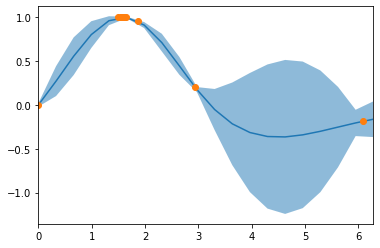

In [45]:
x_scaled = dataset.scale(torch.from_numpy(x))

gaussian_process = botorch.models.SingleTaskGP(x_scaled, torch.from_numpy(y))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood=gaussian_process.likelihood, model=gaussian_process)
botorch.fit.fit_gpytorch_model(mll)

x_test = torch.linspace(0, 1, 20, dtype=torch.double).unsqueeze(dim=1)
posterior = gaussian_process.posterior(x_test)
lower, upper = posterior.mvn.confidence_region()

plt.plot(dataset.rescale(x_test), posterior.mean.detach())
plt.plot(x, y, 'o')
plt.fill_between(dataset.rescale(x_test).squeeze(), lower.detach(), upper.detach(), alpha=0.5);
plt.xlim([0, 2*np.pi]);

**Exercise 4** Do you understand the shape of the confidence bound?

**Exercise 5** Try adding some noise to the observations by adding the key 'noise' to the config dictionary. The corresponding value is the standard deviation of the Gaussian distributed noise. Plot the obtained x and y values. Is the position of the maximum close to the expected maximum at $\pi$/2?

##Regret

The regret is defined as the difference between the true maximum of the function and the best value found so far.

**Exercise 6** Plot the regret as a function of iteration number, using a logarithmic y-axis

In [0]:
running_max = np.maximum.accumulate(y)

Since Bayesian optimization is a stochastic algorithm it can be useful to evaluate the regret over a few different initializations of the algorithm.

**Exercise 7** Run the algorithm 5 times with different random seeds and make a plot of the regret as a function of iteration number

##Comparing acquisition functions

Let us now compare a few acquisition functions. You can specify the key 'acquisition_function' in the config dictionary to switch to 'random' or 'ucb' (Upper Confidence Bound) rather than the default option 'ei' (Expected Improvement)

**Exercise 8** Repeat exercise 6 with a random acquisition function. Which acquisition function leads to the lowest regret?

## Optimizing a 2-dimensional function

**Exercise 9** Try optimizing the [negative Branin function](https://www.sfu.ca/~ssurjano/branin.html) by specifying 'dataset':'branin' in the config dictionary. Make a plot of regret vs iteration number

## Template for optimization of measurement in Labber

A dataset which would perform an experiment in Labber to acquire new datapoints would roughly look like (see also [Labber documentation about scripting](http://labber.org/online-doc/api/ScriptTools.html/)): 

In [0]:
import os
from Labber import ScriptTools

class LabberExperiment(Sine):
    def __init__(self, config={}):
        bounds = torch.tensor([[0, 1]], dtype=torch.double)
        self.min, _ = torch.min(bounds, dim=1, keepdim=True)
        self.min = torch.transpose(self.min, 0, 1)
        self.interval = torch.abs(bounds[:, 0] - bounds[:, 1])
        self.dim = bounds.shape[0]
        self.num_points = config.setdefault('initial_observations', 0)
        self.x = torch.rand(self.num_points, self.dim, dtype=torch.double)
        self.y = self.query(self.x)
        # define measurement objects
        sPath = os.path.dirname(os.path.abspath(__file__))
        self.MeasResonator = ScriptTools.MeasurementObject(\
                os.path.join(sPath, 'TestResonator.hdf5'),
                os.path.join(sPath, 'TestResonatorOut.hdf5'))
        self.MeasResonator.setMasterChannel('Flux bias')

    def query(self, x):
        x_rescaled = self.rescale(x)
        results = []
        for setting in x:
          self.MeasResonator.updateValue('Flux bias', setting.numpy())
          (x,y) = self.MeasResonator.performMeasurement()
          results.append(y)
        return torch.tensor(results, dtype=torch.double).unsqueeze(dim=1)

##Batch mode Bayesian optimization

It is also possible to run Bayesian optimization in batch mode: rather than querying for the next most informative datapoint, we can ask for a batch of N most informative datapoints. This can be especially useful in a simulation, where you can evaluate multiple settings in parallel. More details about batch mode can be found [here](https://botorch.org/docs/batching#docsNav).

##Conclusion

I hope this intro helped to get a basic understanding of Bayesian optimization. If you come up with a way to use it in your own experiments, please let me know, I am curious to hear about it!